# Autoregressive HMM on example session

In [2]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
from fitting_functions import cross_validate_armodel, compute_inputs

one = ONE(mode='remote')

## Parameters

In [3]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 3
num_iters = 100
num_train_batches = 5
method = 'kmeans'
method='prior'
threshold = 0.05
sticky = False

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 10]

var_interest = 'wavelet'


# Sessions with cross-validated results

In [4]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
    if not os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


: 

In [ ]:
KS094 c8d46ee6-eb68-4535-8756-7c9aa32f10e4
PL017 1b61b7f2-a599-4e40-abd6-3e758d2c9e25  # solved
CSHL053 12dc8b34-b18e-4cdd-90a9-da134a9be79c
CSHL053 0deb75fb-9088-42d9-b744-012fb8fc4afb
ibl_witten_27 952870e5-f2a7-4518-9e6d-71585460f6fe
ibl_witten_26 dc21e80d-97d7-44ca-a729-a8e3f9b14305
NYU-46 6434f2f5-6bce-42b8-8563-d93d493613a2
NYU-46 72982282-e493-45ee-87ce-aa45cb3a3ec1
CSHL054 a71175be-d1fd-47a3-aa93-b830ea3634a1
CSHL047 2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e
CSHL059 d16a9a8d-5f42-4b49-ba58-1746f807fcc1
CSHL059 dda5fc59-f09a-4256-9fb5-66c67667a466
SWC_058 d3a2b25e-46d3-4f0b-ade6-4e32255f4c35
CSH_ZAD_011 5b44c40f-80f4-44fb-abfb-c7f19e27a6ca
DY_011 741979ce-3f10-443a-8526-2275620c8473
NYU-46 64e3fb86-928c-4079-865c-b364205b502e
DY_010 4fa70097-8101-4f10-b585-db39429c5ed0
UCLA035 f99ac31f-171b-4208-a55d-5644c0ad51c3
ZFM-01935 f5591ac5-311d-4fa8-9bad-029d7be9c491
UCLA034 ebc9392c-1ecb-4b4b-a545-4e3d70d23611
SWC_053 032452e9-1886-449d-9c13-0f192572e19f

"""
DY_011 cf43dbb1-6992-40ec-a5f9-e8e838d0f643  only captures very low ME, not intermediate oscillations
UCLA034 19b44992-d527-4a12-8bda-aa11379cb08c only captures very low ME, not intermediate oscillations
NYU-11 56956777-dca5-468c-87cb-78150432cc57  only captures very low ME but mostly good actually
ibl_witten_29 d2832a38-27f6-452d-91d6-af72d794136c good
ZFM-02370 6f6d2c8e-28be-49f4-ae4d-06be2d3148c1 good
NYU-48 3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b good
ZFM-01577 09b2c4d1-058d-4c84-9fd4-97530f85baf6 good
KS094 752456f3-9f47-4fbf-bd44-9d131c0f41aa good
UCLA011 824cf03d-4012-4ab1-b499-c83a92c5589e  mostly captures very low ME but mostly good actually
CSH_ZAD_022 a66f1593-dafd-4982-9b66-f9554b6c86b5 good
KS094 6b0b5d24-bcda-4053-a59c-beaa1fe03b8f  mostly captures very low ME but mostly good actually
UCLA034 8a3a0197-b40a-449f-be55-c00b23253bbf  mostly captures very low ME, on very few instances, but makes sense with data?
CSHL060 2e6e179c-fccc-4e8f-9448-ce5b6858a183 good?
NYU-46 6434f2f5-6bce-42b8-8563-d93d493613a2 mostly captures very low ME, on very few instances, but makes sense with data?
UCLA034 3537d970-f515-4786-853f-23de525e110f  mostly captures very low ME, on very few instances, but makes sense with data?
UCLA012 1f095590-6669-46c9-986b-ccaf0620c5e9 good
UCLA037 bda2faf5-9563-4940-a80f-ce444259e47b good
PL017 10fac7a1-919d-4ca7-83c4-4675bd8d9416 mostly captures very low ME, on very few instances, NOT AMAZING?
ZFM-01935 1a507308-c63a-4e02-8f32-3239a07dc578 great
CSHL054 a71175be-d1fd-47a3-aa93-b830ea3634a1 pretty bad, one state basically
UCLA035 6f36868f-5cc1-450c-82fa-6b9829ce0cfe mostly captures very low ME, on very few instances, NOT AMAZING?
ZFM-02368 a4a74102-2af5-45dc-9e41-ef7f5aed88be good
CSHL059 d16a9a8d-5f42-4b49-ba58-1746f807fcc1 good
NYU-45 537677fe-1e24-4755-948c-fa4a4e8ecce5  mostly captures very low ME, on very few instances
PL017 68775ca0-b056-48d5-b6ae-a4c2a76ae48f good
UCLA037 fa8ad50d-76f2-45fa-a52f-08fe3d942345  mostly captures very low ME, on very few instances
DY_011 741979ce-3f10-443a-8526-2275620c8473   mostly captures very low ME, misses a lot of regular modulation
DY_010 4fa70097-8101-4f10-b585-db39429c5ed0  mostly captures very low ME, misses a lot of regular modulation
UCLA035 f99ac31f-171b-4208-a55d-5644c0ad51c3  mostly captures very low ME, misses a lot of regular modulation
UCLA034 ebc9392c-1ecb-4b4b-a545-4e3d70d23611 mostly captures very low ME, on very few instances, but makes sense with data?
SWC_058 3638d102-e8b6-4230-8742-e548cd87a949 good
NYU-48 93ad879a-aa42-4150-83e1-38773c9785e4 good
"""


In [6]:
stop_sessions = ['c8d46ee6-eb68-4535-8756-7c9aa32f10e4',
 '1b61b7f2-a599-4e40-abd6-3e758d2c9e25',
 '12dc8b34-b18e-4cdd-90a9-da134a9be79c',
 '0deb75fb-9088-42d9-b744-012fb8fc4afb',
 '952870e5-f2a7-4518-9e6d-71585460f6fe',
 'dc21e80d-97d7-44ca-a729-a8e3f9b14305',
 '6434f2f5-6bce-42b8-8563-d93d493613a2',
 '72982282-e493-45ee-87ce-aa45cb3a3ec1',
 'a71175be-d1fd-47a3-aa93-b830ea3634a1',
 '2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e',
 'd16a9a8d-5f42-4b49-ba58-1746f807fcc1',
 'dda5fc59-f09a-4256-9fb5-66c67667a466',
 'd3a2b25e-46d3-4f0b-ade6-4e32255f4c35',
 '5b44c40f-80f4-44fb-abfb-c7f19e27a6ca',
 '741979ce-3f10-443a-8526-2275620c8473',
 '64e3fb86-928c-4079-865c-b364205b502e',
 '4fa70097-8101-4f10-b585-db39429c5ed0',
 'f99ac31f-171b-4208-a55d-5644c0ad51c3',
 'f5591ac5-311d-4fa8-9bad-029d7be9c491',
 'ebc9392c-1ecb-4b4b-a545-4e3d70d23611',
 '032452e9-1886-449d-9c13-0f192572e19f']

# Fit best params on individual sessions

In [5]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

fit = True
kappa=1
lag=30
num_states=3
smooth = False
window=6
downsample=False
downsample_factor=2
num_train_batches = 20
method='kmeans'
use_method = 'em'

for m, mat in enumerate(sessions_to_process[:2]): 
    
    mouse_name = mat[0]
    session = mat[1]

    fit_id = str(mouse_name+session)
    
    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get standardized design_matrix
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]

    num_timesteps = np.shape(design_matrix)[0]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    # data = np.array(unnorm_design_matrix[var_names])[:(num_timesteps // num_train_batches) * num_train_batches].reshape(-1, 1)

    if fit:
        # Prepare data format
        emission_dim = np.shape(design_matrix)[1]
        if smooth:
            df = pd.DataFrame(data, columns=["Signal"])
            smoothed_signal = df["Signal"].rolling(window=window, center=True).mean().to_numpy()
            shortened_array = np.array(data)
            shortened_array[int(np.ceil(window/2)):-int(np.floor(window/2))] = smoothed_signal[int(np.ceil(window/2)):-int(np.floor(window/2))].reshape(-1, 1)
        else:
            shortened_array = np.array(data)        
        
        if downsample:
            # Downsample
            downsampled = shortened_array[::downsample_factor].copy()
            shortened_array = downsampled[:(np.shape(downsampled)[0] // num_train_batches) * num_train_batches]

        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        " Fit model with best params"
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, lag, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

        # Initialize new hmm and fit
        arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=lag,transition_matrix_stickiness=kappa)
        # init_params, props = arhmm.initialize(key=jr.PRNGKey(0), method=method, emissions=shortened_array)  # not sure if I need to include  
        all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(
                            arhmm, jr.PRNGKey(0), train_emissions, train_inputs, method, num_train_batches, use_method
                        )
        
        # Find parameters for best fold
        use_fold = np.where(all_val_lls == np.nanmax(all_val_lls))[0][0]

        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        

        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=lag, transition_matrix_stickiness=kappa)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases,
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include

        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

    else:
        # Get most likely states
        result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
        most_likely_states, use_fold, best_params = pickle.load(open(result_filename, "rb"))
        state_number, lag_number, kappa_number = best_params
        shortened_array = np.array(data)  

    
    " Plots "
    # Prepare data

    design_matrix_heading = pd.DataFrame(columns=var_names)
    design_matrix_heading[var_names] = shortened_array[0:len(most_likely_states)] # TODO: need to understand why number is the same and whether it depends on lag
    # bins = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    # design_matrix_heading['Bin'] = bins
    
    if smooth:
        plot_data = design_matrix_heading[var_names].rolling(window=window, center=True).median()
    else:
        plot_data = design_matrix_heading[var_names]
        
    # Plot raw trace over states
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
    plt.rc('font', size=12)
    ax.plot(plot_data)
    ax.imshow(np.concatenate([most_likely_states])[None,:], 
                extent=(0, len(np.concatenate([most_likely_states])), -4, 4),
                aspect="auto",
                cmap='viridis',
                alpha=0.3) 
    if fit:
        ax.set_title(mouse_name+' '+session+' '+str(lag)+' '+str(kappa))
    else:
        ax.set_title(mouse_name+' '+session+' '+str(lag_number)+' '+str(kappa_number))        

    init = 2000
    ax.set_xlim([init, init+1000])
    plt.show()
    print(fit_id)

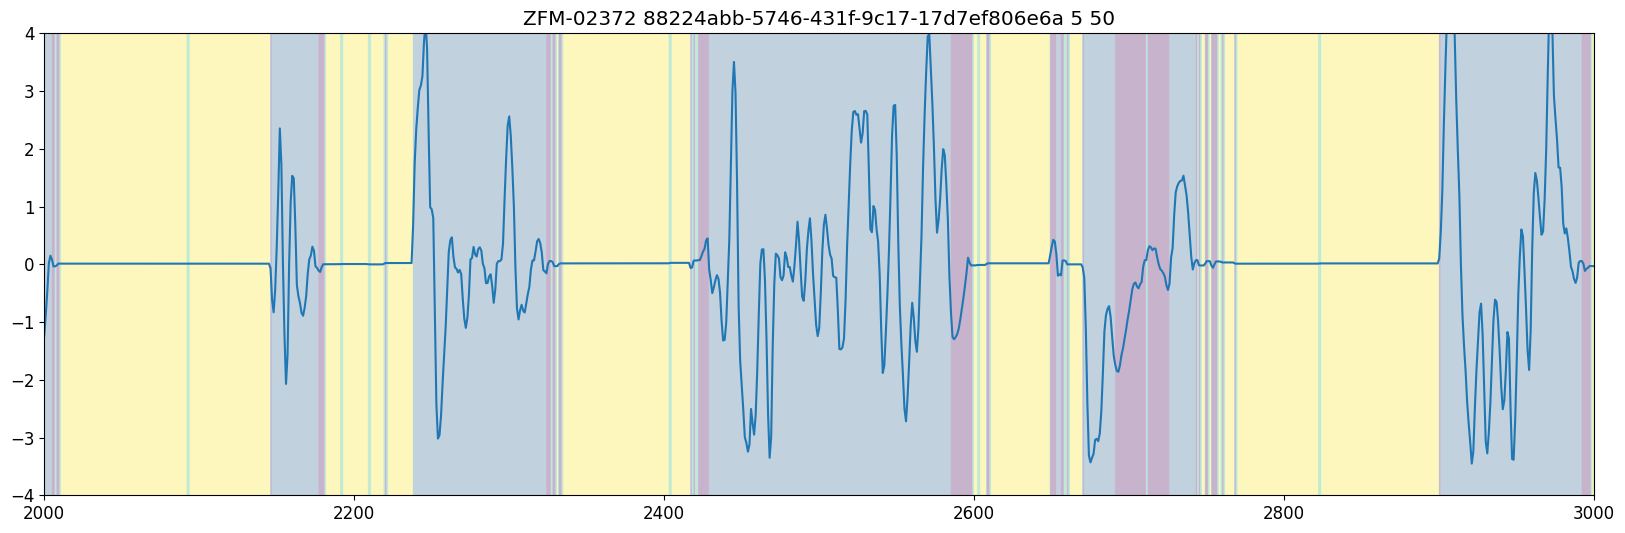

ZFM-0237288224abb-5746-431f-9c17-17d7ef806e6a


In [53]:
    # Plot raw trace over states
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
    plt.rc('font', size=12)
    ax.plot(plot_data)
    ax.imshow(np.concatenate([most_likely_states])[None,:], 
                extent=(0, len(np.concatenate([most_likely_states])), -4, 4),
                aspect="auto",
                cmap='viridis',
                alpha=0.3) 
    if fit:
        ax.set_title(mouse_name+' '+session+' '+str(lag)+' '+str(kappa))
    else:
        ax.set_title(mouse_name+' '+session+' '+str(lag_number)+' '+str(kappa_number))        

    init = 2000
    ax.set_xlim([init, init+1000])
    plt.show()
    print(fit_id)